In [1]:
import os

# Limit the number of threads for various libraries
os.environ["MKL_NUM_THREADS"] = "12"  # For MKL (used by NumPy)
os.environ["NUMEXPR_NUM_THREADS"] = "12"  # For NumExpr
os.environ["VECLIB_MAXIMUM_THREADS"] = "12"  # For macOS Accelerate
os.environ["OPENBLAS_NUM_THREADS"] = "12"  # For OpenBLAS
os.environ["BLIS_NUM_THREADS"] = "12"  # For BLIS

# Print environment variables to verify
print("OMP_NUM_THREADS:", os.environ.get("OMP_NUM_THREADS"))
print("MKL_NUM_THREADS:", os.environ.get("MKL_NUM_THREADS"))
print("NUMEXPR_NUM_THREADS:", os.environ.get("NUMEXPR_NUM_THREADS"))
print("VECLIB_MAXIMUM_THREADS:", os.environ.get("VECLIB_MAXIMUM_THREADS"))
print("OPENBLAS_NUM_THREADS:", os.environ.get("OPENBLAS_NUM_THREADS"))
print("BLIS_NUM_THREADS:", os.environ.get("BLIS_NUM_THREADS"))

# Set PyTorch threads
import torch
torch.set_num_threads(18)
torch.set_num_interop_threads(18)

OMP_NUM_THREADS: None
MKL_NUM_THREADS: 12
NUMEXPR_NUM_THREADS: 12
VECLIB_MAXIMUM_THREADS: 12
OPENBLAS_NUM_THREADS: 12
BLIS_NUM_THREADS: 12


In [2]:
# WrappedProteinDataset & PCAExplainability - Usage Demo
# ======================================================
# This notebook demonstrates how to use WrappedProteinDataset and PCAExplainability
# to perform dimensionality reduction and interpret protein embedding data.

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

from project_root.dataset.dataset_loader import DatasetLoader
from project_root.dataset.protein_dataset import ProteinDataset
from project_root.dataset.wrapped_protein_dataset import WrappedProteinDataset
from project_root.explainability.pca_explainability import PCAExplainability

from torch.utils.data import DataLoader, TensorDataset

from project_root.dataset.protein_dataset import ProteinDataset
from project_root.dataset.wrapped_protein_dataset import WrappedProteinDataset
from project_root.models.protein_classifier import ProteinClassifier
from project_root.training.trainer import Trainer

# ------------------------------------------------------
# 📥 1. Load Dataset and Embeddings
# ------------------------------------------------------

# Define data path
path_dataset_folder = "../DATASETS/"

# Load data
loader = DatasetLoader(path_dataset_folder)
df = loader.load_dataframe()
embeddings, attention_weights = loader.load_embeddings_and_attention()

# Create ProteinDataset instance
protein_dataset = ProteinDataset(df, embeddings, attention_weights, solve_inconsistencies=True)

Checking consistency...
Removing duplicate entries...
 - DataFrame IDs: 1249
 - Embeddings IDs: 1219
 - Attention Weights IDs: 1219
Resolving inconsistencies. Keeping 1219 common samples.
Consistency checked.

ProteinDataset Report:
 - Number of samples: 1219
 - Number of embeddings: 1219
 - Number of attention weights: 1219
 - Target column: Class
 - ID column: UniProt IDs
 - Save path: ./OUTPUTS/



In [3]:
# ------------------------------------------------------
# 🧪 2. Create WrappedProteinDataset with Configurations
# ------------------------------------------------------

wrapped_dataset = WrappedProteinDataset(
    dataset=protein_dataset,
    reduce_method='pca',              # or 'tsne'
    pca_method='threshold',           # 'threshold', 'derivative', 'custom'
    threshold=0.95,
    random_projection_dim=800        # Random projection dim before PCA on attention weights
)

Converting embeddings and attention weights to NumPy arrays...
Applying random projection to reduce attention weights from 6255001 to 800 dimensions...
Applying dimensionality reduction using pca...


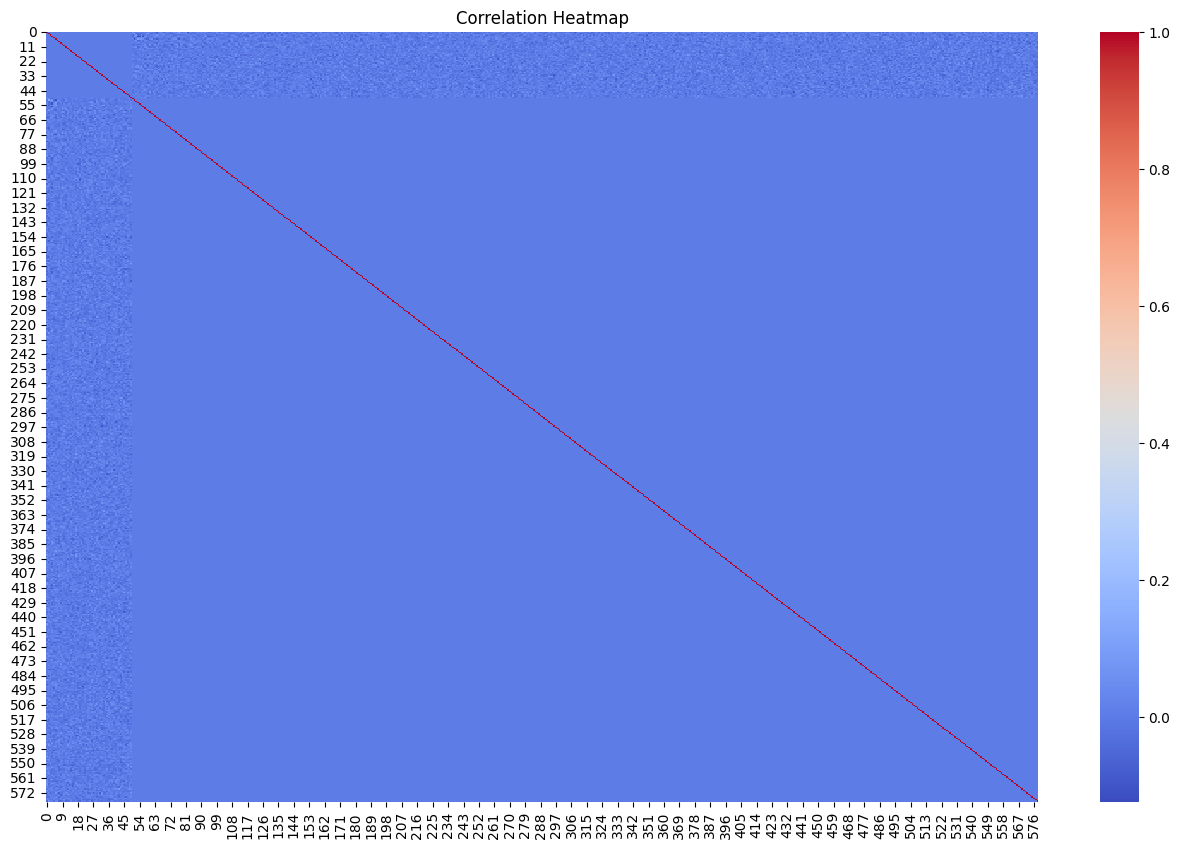

In [7]:
wrapped_dataset.plot_correration_heatmap(embedding=True, attention_weights=True)

Epoch 1, Training Loss: 0.6898, Validation Loss: 0.6874, Training Accuracy: 0.5538, Validation Accuracy: 0.5820
Epoch 2, Training Loss: 0.6888, Validation Loss: 0.6867, Training Accuracy: 0.5538, Validation Accuracy: 0.5820
Epoch 3, Training Loss: 0.6878, Validation Loss: 0.6862, Training Accuracy: 0.5538, Validation Accuracy: 0.5820
Epoch 4, Training Loss: 0.6865, Validation Loss: 0.6856, Training Accuracy: 0.5538, Validation Accuracy: 0.5820
Epoch 5, Training Loss: 0.6857, Validation Loss: 0.6852, Training Accuracy: 0.5538, Validation Accuracy: 0.5820
Epoch 6, Training Loss: 0.6840, Validation Loss: 0.6847, Training Accuracy: 0.5538, Validation Accuracy: 0.5820
Epoch 7, Training Loss: 0.6822, Validation Loss: 0.6843, Training Accuracy: 0.5538, Validation Accuracy: 0.5820
Epoch 8, Training Loss: 0.6802, Validation Loss: 0.6839, Training Accuracy: 0.5538, Validation Accuracy: 0.5820
Epoch 9, Training Loss: 0.6772, Validation Loss: 0.6836, Training Accuracy: 0.5538, Validation Accuracy:

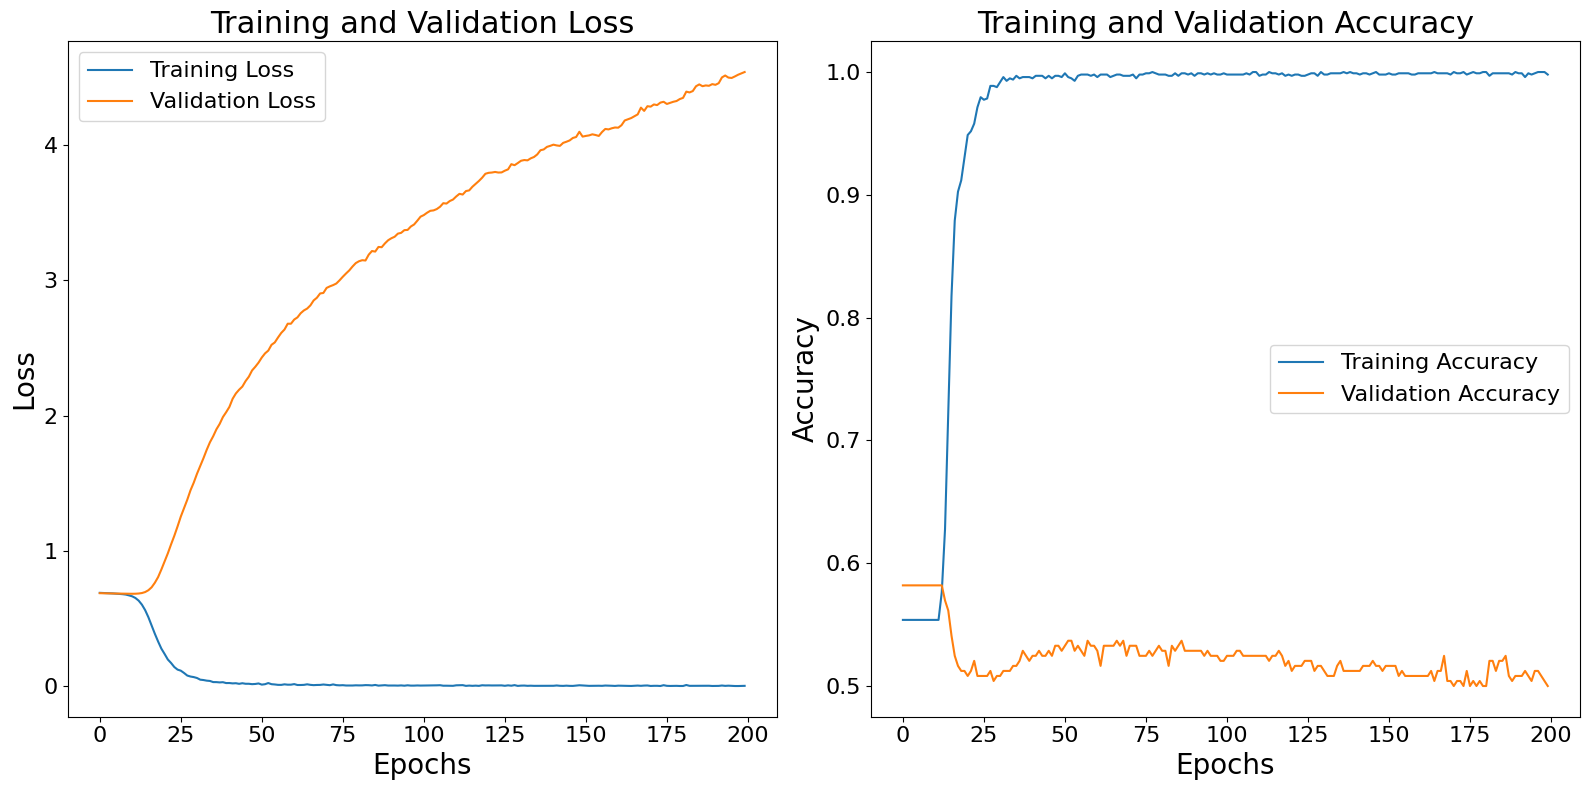

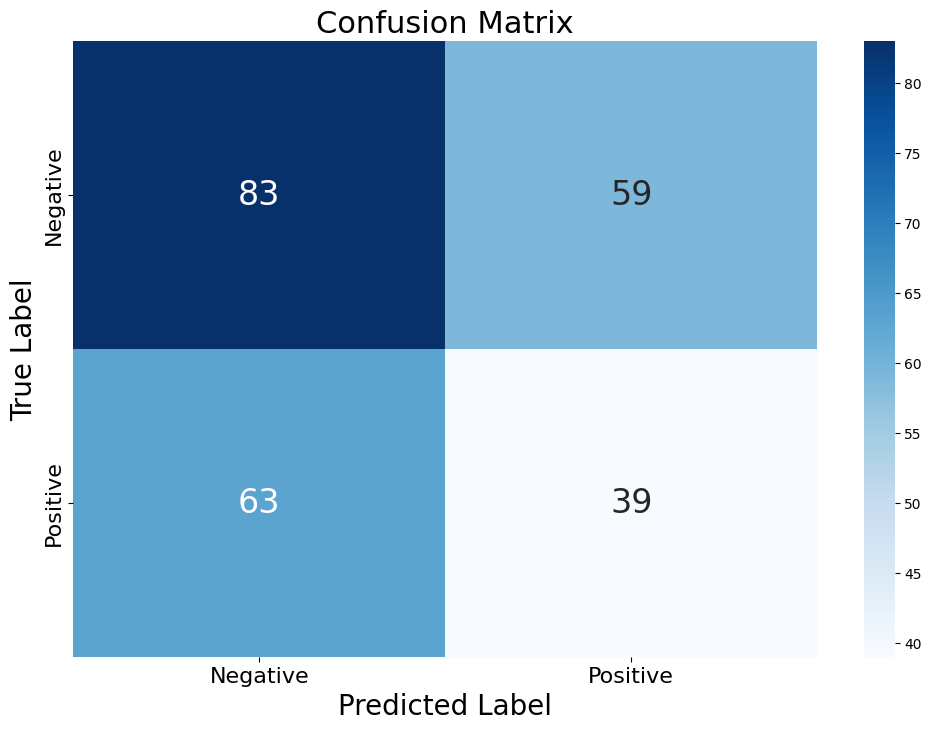


Métricas de Evaluación:
              precision    recall  f1-score   support

    Negative       0.57      0.58      0.58       142
    Positive       0.40      0.38      0.39       102

    accuracy                           0.50       244
   macro avg       0.48      0.48      0.48       244
weighted avg       0.50      0.50      0.50       244

Especificidad: 0.5845
Estadístico Kappa: -0.0333
✅ ProteinClassifier + Trainer test complete


In [11]:
# -----------------------------------------
# 🧪 Prepare dataloaders
# -----------------------------------------
X = torch.tensor(wrapped_dataset.attention_weights, dtype=torch.float32)
y = torch.tensor(protein_dataset.get_labels(), dtype=torch.float32)

dataset = TensorDataset(X, y)
split = int(0.8 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [split, len(dataset) - split])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# -----------------------------------------
# 🧠 Build and train model
# -----------------------------------------
input_size = X.shape[1]
model_fn = lambda size: ProteinClassifier(
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    input_size=input_size,
    output_size=1,
    num_hidden_layers=3,
    hidden_layers_mode='quadratic_increase'
)

trainer = Trainer(model_class=model_fn)
train_losses, val_losses, train_accs, val_accs = trainer.train_and_validate(train_loader, test_loader, num_epochs=200)

# -----------------------------------------
# 📈 Visualize results and evaluate
# -----------------------------------------
trainer.plot_results(train_losses, val_losses, train_accs, val_accs)
trainer.evaluate_and_plot_confusion_matrix(test_loader)

print("✅ ProteinClassifier + Trainer test complete")
